In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

from src.model import get_model, get_resnet18_cifar100
from src.data import get_data, get_ood_data
from src.ood_scores import OODEvaluator
from src.neural_collapse import compute_nc_metrics

from matplotlib.colors import TwoSlopeNorm
from sklearn.decomposition import PCA
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128

In [2]:
train_loader, test_loader = get_data(BATCH_SIZE)
ood_loader = get_ood_data(BATCH_SIZE)

model_state = torch.load("models_weights/resnet18_cifar100.pth")
model = get_model().to(device)
model.load_state_dict(model_state["model_state_dict"])

<All keys matched successfully>

In [3]:
evaluator = OODEvaluator(model)
features, logits = evaluator.get_features_and_logits(test_loader, device)
test_labels = torch.cat([l for _, l in test_loader])
weights = model.base_model.fc.weight.detach().cpu()

metrics = compute_nc_metrics(features.cpu(), test_labels.cpu(), weights)


In [4]:
def plot_nc1(features, labels, means):
    """
    NC1 Analysis: Intra-class variability collapse.
    Shows how tightly samples cluster around their class means relative to 
    the separation between classes.
    """
    intra_distances = []
    num_classes = means.shape[0]
    
    for i in range(num_classes):
        mask = (labels == i)
        if mask.sum() > 0:
            diff = features[mask] - means[i]
            intra_distances.append(torch.norm(diff, dim=1))
    
    all_intra = torch.cat(intra_distances)
    
    mu_g = means.mean(dim=0) # Global mean
    inter_dist = torch.norm(means - mu_g, dim=1).mean()
    
    # Ratio < 1 = cluster is tighter than the global spread
    collapsed_distances = (all_intra / inter_dist).cpu().numpy()
    avg_nc1 = collapsed_distances.mean()
    
    plt.figure(figsize=(10, 7), facecolor='white')
    
    n, bins, patches = plt.hist(
        collapsed_distances, bins=80, 
        color='#4a69bd', alpha=0.7, 
        edgecolor='#2f3542', linewidth=0.5
    )

    plt.axvline(avg_nc1, color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean NC1 Ratio: {avg_nc1:.4f}')

    plt.title("NC1: Intra-class Variability Collapse", fontsize=16, fontweight='normal', pad=20)
    plt.xlabel("Relative Distance (Intra-class spread / Inter-class separation)", fontsize=12)
    plt.ylabel("Number of Samples", fontsize=12)
    
    plt.xlim(0, min(max(collapsed_distances), avg_nc1 * 3))
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().yaxis.grid(True, linestyle='--', alpha=0.3)

    plt.text(avg_nc1 * 1.1, max(n) * 0.8, 
             f"Ideal NC1 $\\rightarrow$ 0\nMeasured: {avg_nc1:.4f}", 
             fontsize=11, color='#c0392b', bbox=dict(facecolor='white', alpha=0.5))

    plt.legend(frameon=True)
    plt.tight_layout()
    plt.show()

    return avg_nc1

In [5]:
def plot_nc2(means, grid_step=10):
    """
    NC2 Analysis: High-contrast matrix with a clear grid for better visual separation.
    """
    mu_g = means.mean(dim=0)
    norm_means = F.normalize(means - mu_g, p=2, dim=1)
    
    cosine_sim = torch.mm(norm_means, norm_means.T).cpu().numpy()
    num_classes = means.shape[0]
    etf_target = -1 / (num_classes - 1)
    
    plt.figure(figsize=(11, 9), facecolor='white')
    
    # Normalization focused on the ETF target
    norm = TwoSlopeNorm(vcenter=etf_target, vmin=-1.0, vmax=1.0)
    img = plt.imshow(cosine_sim, cmap='RdBu_r', norm=norm, interpolation='nearest')

    mask = ~torch.eye(num_classes, dtype=bool)
    off_diag_avg = cosine_sim[mask].mean().item()
    print(f"Experimental Mean Similarity: {off_diag_avg:.6f}")
    
    for i in range(0, num_classes, grid_step):
        plt.axhline(i - 0.5, color='black', linewidth=0.5, alpha=0.3)
        plt.axvline(i - 0.5, color='black', linewidth=0.5, alpha=0.3)

    cbar = plt.colorbar(img)
    cbar.set_label("Cosine Similarity", fontsize=12)
    
    plt.title(f"NC2: Simplex ETF Correlation Matrix", 
              fontsize=16, fontweight='normal', pad=20)
    plt.xlabel("Class Index", fontsize=12)
    plt.ylabel("Class Index", fontsize=12)
    
    plt.xlim(-0.5, num_classes - 0.5)
    plt.ylim(num_classes - 0.5, -0.5)
    
    plt.tight_layout()
    plt.show()

In [6]:
def plot_nc3(model, means):
    """
    NC3 Analysis: Verifies Self-Duality (alignment between classifier weights 
    and class centroids). In a collapsed state, weights and means should align.
    """
    weights = model.base_model.fc.weight.detach().cpu()
    w_norm = F.normalize(weights, p=2, dim=1)
    
    mu_g = means.cpu().mean(dim=0)
    m_centered = means.cpu() - mu_g
    m_norm = F.normalize(m_centered, p=2, dim=1)
    
    # 2. Cross-correlation and Alignment
    cross_sim = torch.mm(w_norm, m_norm.T)
    
    # Max similarity per class (diagonal after potential remapping)
    best_alignment, _ = cross_sim.max(dim=1)
    avg_nc3 = best_alignment.mean().item()

    plt.figure(figsize=(10, 7), facecolor='white')
    plt.hist(best_alignment.numpy(), bins=30, color='#27ae60', 
             alpha=0.6, edgecolor='#1e8449', linewidth=1.2)
    
    plt.axvline(avg_nc3, color='#c0392b', linestyle='--', linewidth=2, 
                label=f'Mean Alignment: {avg_nc3:.4f}')
    
    plt.title("NC3: Classifier Weight and Class Mean Alignment (Self-Duality)", 
              fontsize=15, fontweight='normal', pad=20)
    plt.xlabel("Cosine Similarity", fontsize=12)
    plt.ylabel("Number of Classes", fontsize=12)
    
    plt.xlim(0, 1.1)
    plt.gca().yaxis.grid(True, linestyle='--', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.legend(frameon=True, fontsize=11)
    plt.tight_layout()
    plt.show()
    
    return avg_nc3

In [7]:
def extract_layer_features(model, layer, loader, device):
    """
    Extrait les caractéristiques d'une couche spécifique et les labels associés.
    """
    model.eval()
    labels_list = []
    tmp_storage = []

    def hook_fn(module, input, output):
        # output.shape : [B, C, H, W]
        pooled_output = F.adaptive_avg_pool2d(output, (1, 1)).flatten(1) # [B, C]
        tmp_storage.append(pooled_output.detach().cpu())

    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            model(images)
            labels_list.append(labels.cpu())
            
    handle.remove()

    features = torch.cat(tmp_storage, dim=0)
    all_labels = torch.cat(labels_list, dim=0)

    return features, all_labels

In [8]:
def plot_nc4(model, test_loader, class_means, device):
    """
    NC4 Analysis: Compares original Softmax accuracy vs. Nearest Class Center (NCC).
    In the Terminal Phase of Training (TPT), the gap should vanish.
    """
    model.eval()
    all_logits = []
    all_features = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            output = model(inputs)
            features = output[0] if isinstance(output, tuple) else output
            logits = output[1] if isinstance(output, tuple) else None
            
            all_features.append(features.cpu())
            if logits is not None:
                all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

    test_features = torch.cat(all_features)
    test_labels = torch.cat(all_labels)
    
    # Softmax Model Accuracy
    if len(all_logits) > 0:
        test_logits = torch.cat(all_logits)
        acc_softmax = (test_logits.argmax(dim=1) == test_labels).float().mean().item() * 100
    else: acc_softmax = 0.0 

    # NCC Accuracy (Geometric Decision)
    mu_g = class_means.mean(dim=0).cpu()
    feat_norm = F.normalize(test_features - mu_g, p=2, dim=1)
    means_norm = F.normalize(class_means.cpu() - mu_g, p=2, dim=1)
    
    cos_sim = torch.mm(feat_norm, means_norm.T)
    preds_ncc = cos_sim.argmax(dim=1)
    acc_ncc = (preds_ncc == test_labels).float().mean().item() * 100

    plt.figure(figsize=(9, 7), facecolor='white')
    labels = ['Softmax (Network)', 'NCC (Geometric)']
    accuracies = [acc_softmax, acc_ncc]
    
    colors = ['#4a69bd', '#7f8c8d']
    bars = plt.bar(labels, accuracies, color=colors, alpha=0.8, width=0.4)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1.5,
                 f'{height:.2f}%', ha='center', va='bottom', fontsize=12)

    plt.ylim(0, 110)
    gap = abs(acc_softmax - acc_ncc)
    plt.title(f"NC4: Decision Rule Convergence (Gap: {gap:.4f}%)", 
              fontsize=15, fontweight='normal', pad=20)
    plt.ylabel("Test Accuracy (%)", fontsize=12)
    
    plt.gca().yaxis.grid(True, linestyle='--', alpha=0.3)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

    return acc_softmax, acc_ncc

In [9]:
def plot_progressive_pca(model, loader, device):
    """
    Final professional version: 2x2 grid, identical square boxes, high contrast.
    Titles are set to normal weight (not bold).
    """
    layers = [
        model.base_model.layer1, 
        model.base_model.layer2, 
        model.base_model.layer3, 
        model.base_model.layer4
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12), facecolor='white')
    axes = axes.flatten()
    
    target_classes = [0, 10, 20, 30, 40] 
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    for idx, layer in enumerate(layers):
        feats, lbls = extract_layer_features(model, layer, loader, device)
        
        mask = torch.tensor([l in target_classes for l in lbls])
        f_sub = feats[mask].numpy()
        l_sub = lbls[mask].numpy()
        
        pca = PCA(n_components=2)
        projected = pca.fit_transform(f_sub)
        
        ax = axes[idx]
        for i, c in enumerate(target_classes):
            c_mask = l_sub == c
            ax.scatter(
                projected[c_mask, 0], 
                projected[c_mask, 1], 
                color=colors[i],
                label=f'Class {c}', 
                s=25, 
                alpha=0.7, 
                edgecolors='w', 
                linewidths=0.3
            )
        
        ax.set_box_aspect(1) 
        
        ax.set_title(f"Layer {idx+1}", fontsize=16, fontweight='normal', pad=15)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('#888888')
            spine.set_linewidth(1.0)

    plt.suptitle("Geometric Evolution and Neural Collapse Across Layers", 
                 fontsize=22, fontweight='normal', y=0.96)
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.05),
               ncol=5, fontsize=13, frameon=True)

    plt.tight_layout(rect=[0, 0.08, 1, 0.93])
    plt.show()

In [10]:
features_final, labels_final = extract_layer_features(model, model.base_model.layer4, test_loader, device)

class_means = []
for i in range(100):
    mask = (labels_final == i)
    class_means.append(features_final[mask].mean(dim=0))
class_means = torch.stack(class_means)

fc_weights = model.base_model.fc.weight.detach().cpu()

Ce plot montre la distance entre chaque image et le centre de sa classe. Plus la courbe est étroite et proche de 0, plus le réseau a réussi à "effacer" les différences inutiles entre les images d'une même catégorie

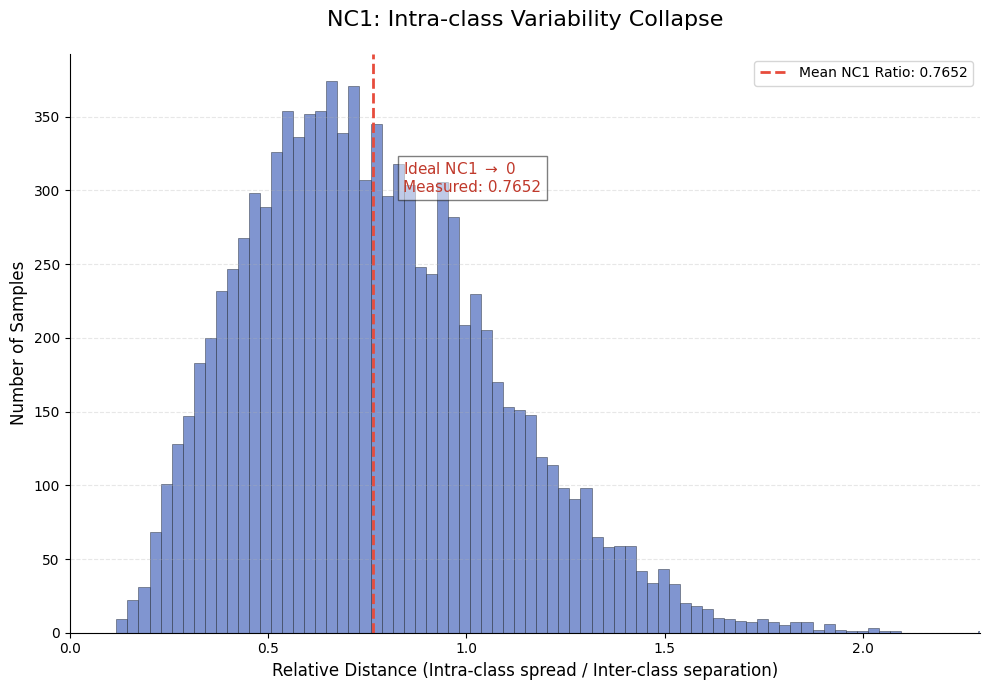

0.76519084

In [11]:
plot_nc1(features_final, labels_final, class_means)

Description : La heatmap affiche la corrélation entre les classes. Un modèle parfait montre une diagonale rouge (corrélation 1 avec soi-même) et un fond bleu uniforme (toutes les classes sont également éloignées les unes des autres).

Experimental Mean Similarity: -0.009038


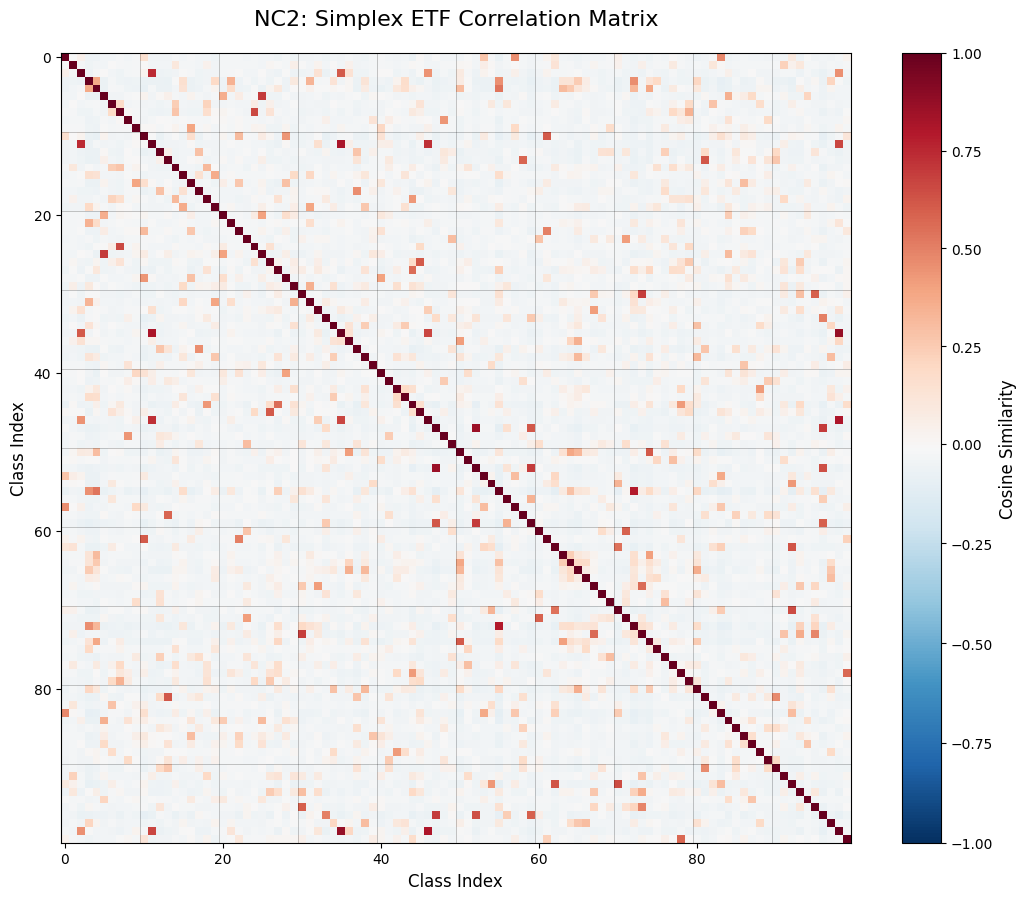

In [12]:
plot_nc2(class_means)

Description : * NC3 (Gauche) : Vérifie si les poids que le réseau utilise pour décider correspondent aux moyennes des images qu'il a vues.

NC4 (Droite) : Compare l'intelligence du modèle avec une simple règle géométrique. Si les barres sont égales, la géométrie explique 100% de la performance.

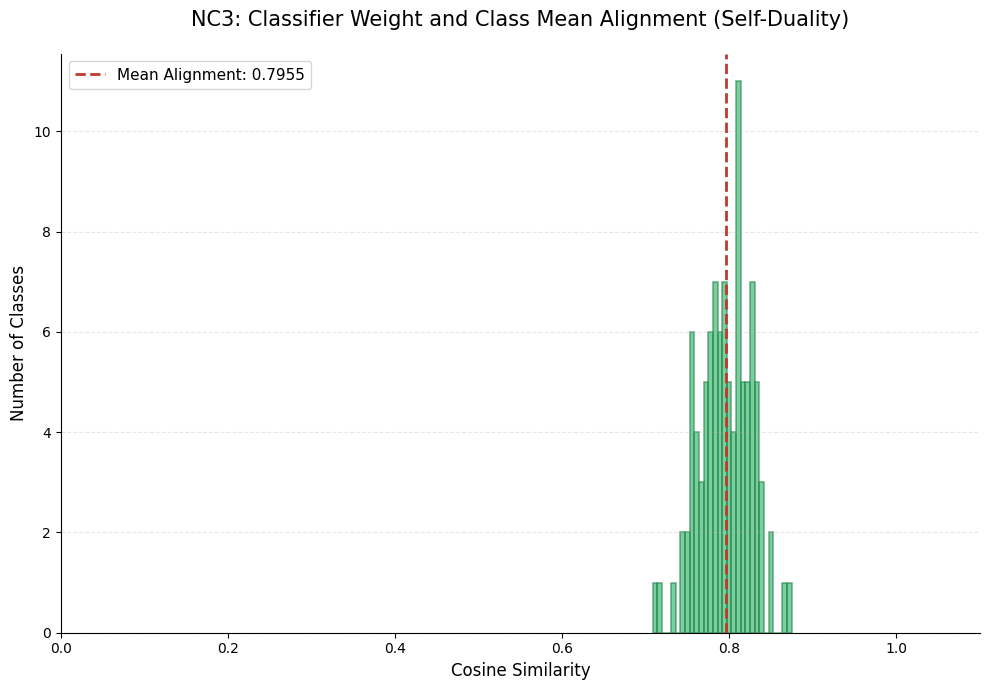

0.7954908609390259

In [13]:
plot_nc3(model, class_means)

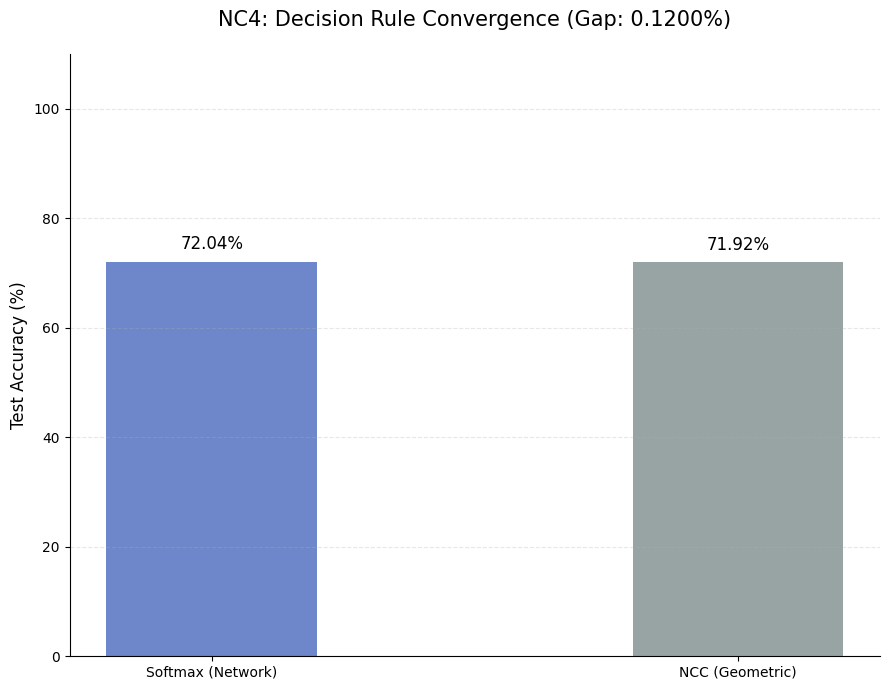

(72.03999757766724, 71.92000150680542)

In [14]:
plot_nc4(model, test_loader, class_means, device)

Description : C'est la vue "systémique". On observe comment le chaos des premières couches (Layer 1) se transforme en clusters organisés à la fin (Layer 4). C'est la preuve visuelle que le réseau apprend à séparer les concepts.

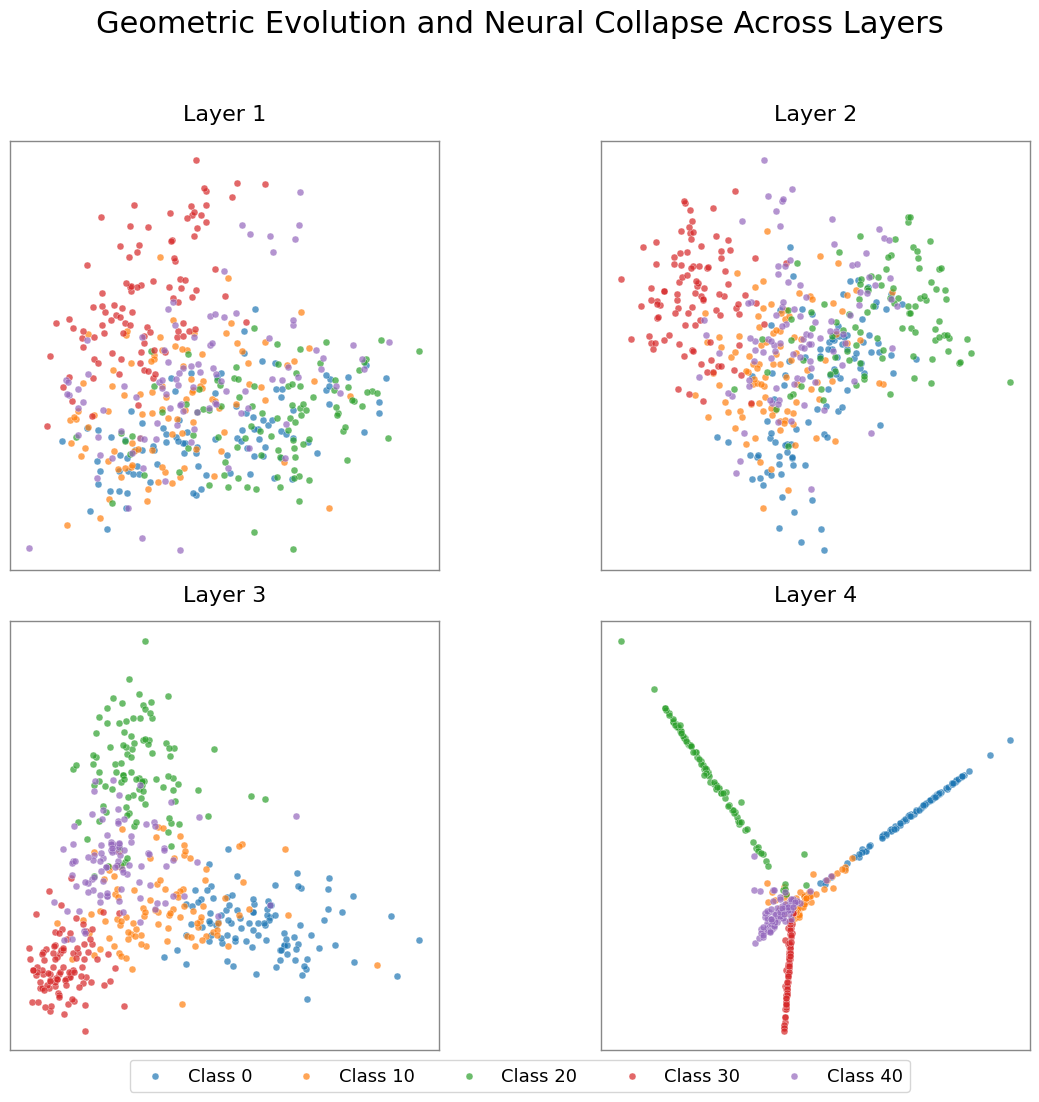

In [15]:
plot_progressive_pca(model, test_loader, device)

torch.Size([3, 32, 32])


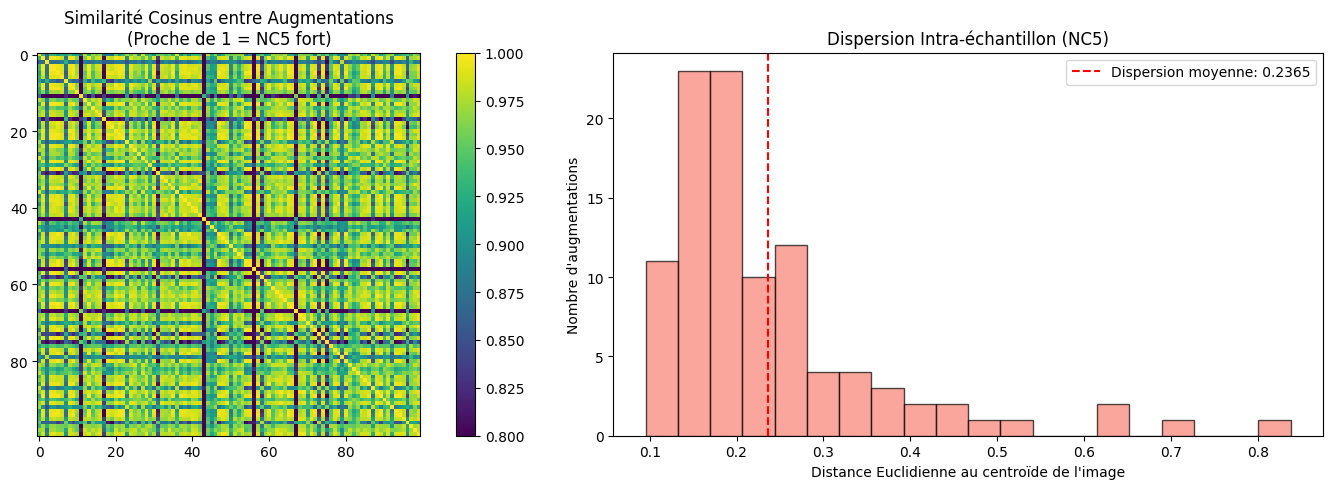

Dispersion moyenne NC5 : 0.2365


In [22]:
def analyze_nc5_invariance(model, image, transform_pipeline, n_augmentations=50):
    """
    Analyse l'invariance NC5 en comparant les embeddings d'une image augmentée.
    """
    model.eval()
    device = next(model.parameters()).device
    
    augmented_images = torch.stack([transform_pipeline(image) for _ in range(n_augmentations)]).to(device)
    
    with torch.no_grad():
        output = model(augmented_images)
        
        if isinstance(output, tuple):
            features = output[0] if output[0].dim() == 2 else output[1]
        else: features = output
            
        features = F.normalize(features, p=2, dim=1)
        
    sim_matrix = torch.matmul(features, features.T).cpu().numpy()
    
    centroid = features.mean(dim=0, keepdim=True)
    centroid = F.normalize(centroid, p=2, dim=1)
    dist_to_centroid = torch.norm(features - centroid, dim=1).cpu().numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    im = ax1.imshow(sim_matrix, cmap='viridis', vmin=0.8, vmax=1.0)
    ax1.set_title("Similarité Cosinus entre Augmentations\n(Proche de 1 = NC5 fort)")
    plt.colorbar(im, ax=ax1)
    
    ax2.hist(dist_to_centroid, bins=20, color='salmon', edgecolor='black', alpha=0.7)
    ax2.axvline(dist_to_centroid.mean(), color='red', linestyle='--', 
        label=f'Dispersion moyenne: {dist_to_centroid.mean():.4f}')
    ax2.set_title("Dispersion Intra-échantillon (NC5)")
    ax2.set_xlabel("Distance Euclidienne au centroïde de l'image")
    ax2.set_ylabel("Nombre d'augmentations")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return dist_to_centroid.mean()

test_invariance_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(32, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

sample_image = next(iter(train_loader))[0].cpu()[0]
print(sample_image.shape)

avg_dispersion = analyze_nc5_invariance(
    model=model, 
    image=sample_image, 
    transform_pipeline=test_invariance_transform, 
    n_augmentations=100
)

print(f"Dispersion moyenne NC5 : {avg_dispersion:.4f}")

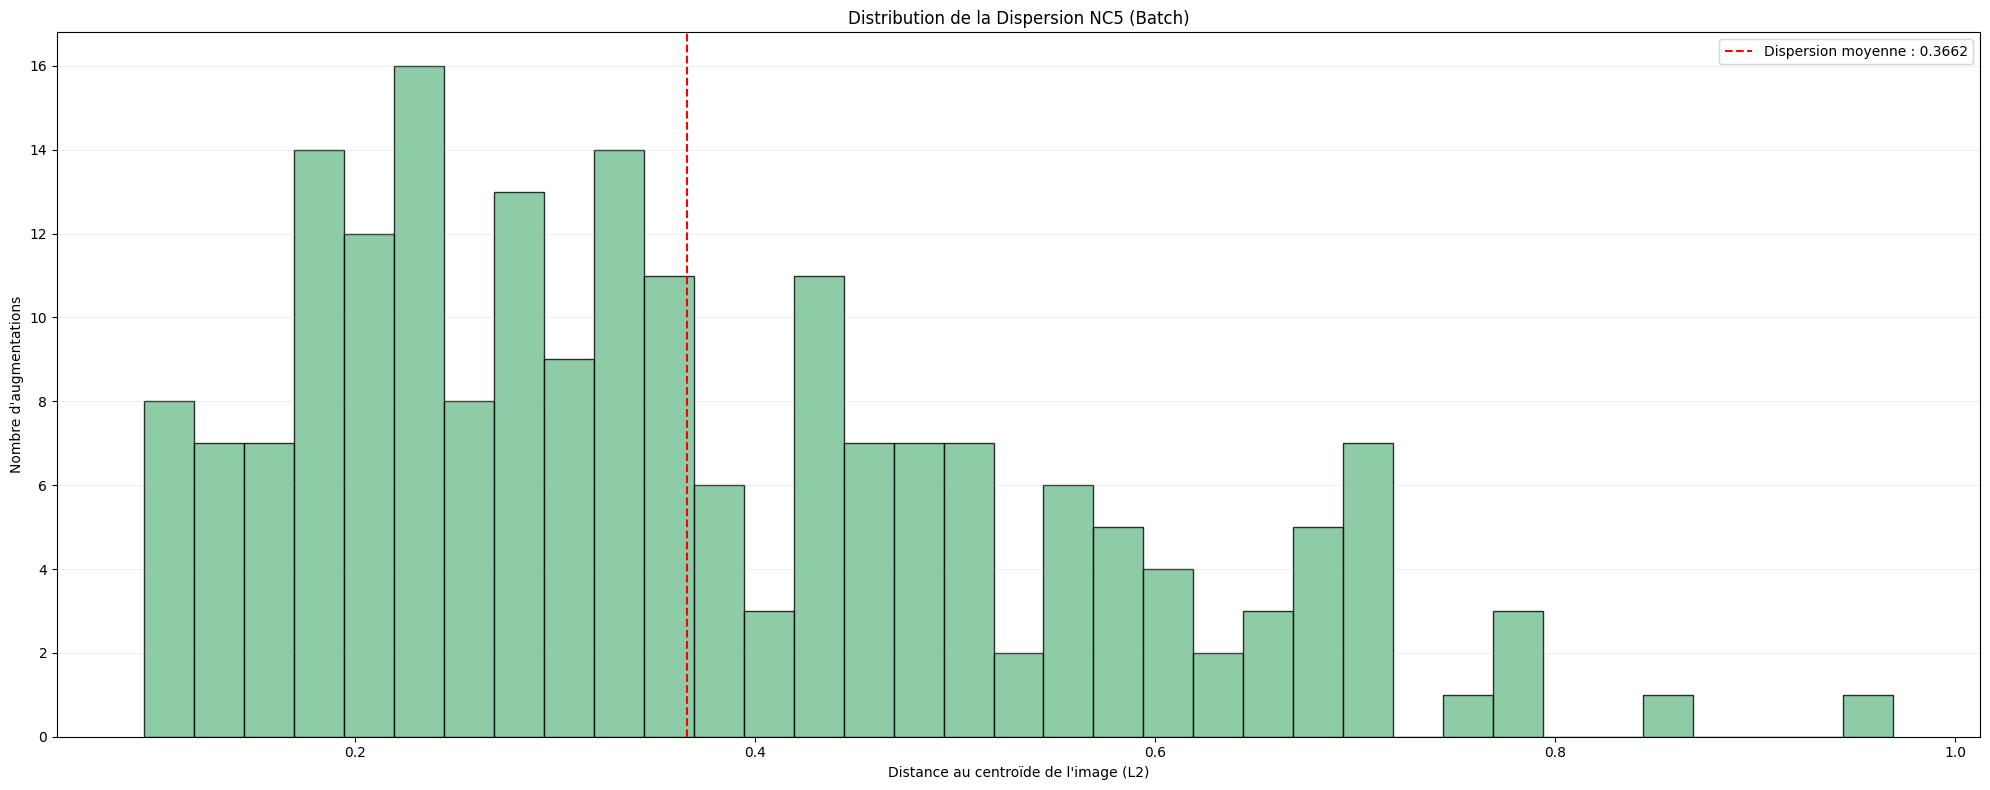

In [17]:
def analyze_nc5_full_batch(model, dataloader, transform_pipeline, n_images=10, n_augmentations=20):
    """
    Analyse NC5 complète : Matrice de similarité par blocs + Histogramme de dispersion.
    """
    model.eval()
    device = next(model.parameters()).device
    
    # 1. Récupération d'un échantillon du batch
    images, _ = next(iter(dataloader))
    images = images[:n_images] 
    
    all_features = []
    all_dispersions = []

    with torch.no_grad():
        for i in range(n_images):
            aug_imgs = torch.stack([transform_pipeline(images[i]) for _ in range(n_augmentations)]).to(device)
            
            output = model(aug_imgs)
            f = output[0] if isinstance(output, tuple) and output[0].dim() == 2 else output
            if isinstance(f, tuple): f = f[1]
            
            f = F.normalize(f, p=2, dim=1)
            
            centroid = F.normalize(f.mean(dim=0, keepdim=True), p=2, dim=1)
            dists = torch.norm(f - centroid, dim=1)
            
            all_features.append(f)
            all_dispersions.append(dists.cpu())

    full_features = torch.cat(all_features)
    all_dispersions = torch.cat(all_dispersions).numpy()
    avg_nc5 = all_dispersions.mean()
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))

    # B. Histogramme de Dispersion Intra-échantillon
    ax.hist(all_dispersions, bins=35, color='#72c091', edgecolor='black', alpha=0.8)
    ax.axvline(avg_nc5, color='red', linestyle='--', label=f'Dispersion moyenne : {avg_nc5:.4f}')
    ax.set_title("Distribution de la Dispersion NC5 (Batch)")
    ax.set_xlabel("Distance au centroïde de l'image (L2)")
    ax.set_ylabel("Nombre d'augmentations")
    ax.legend()
    ax.grid(axis='y', alpha=0.2)

    plt.tight_layout()
    plt.show()

    return avg_nc5

nc5_batch_score = analyze_nc5_full_batch(
    model=model, 
    dataloader=train_loader, 
    transform_pipeline=test_invariance_transform, 
    n_images=10, 
    n_augmentations=20
)

/tmp/ipykernel_1001803/625436166.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Dark2', n_images)


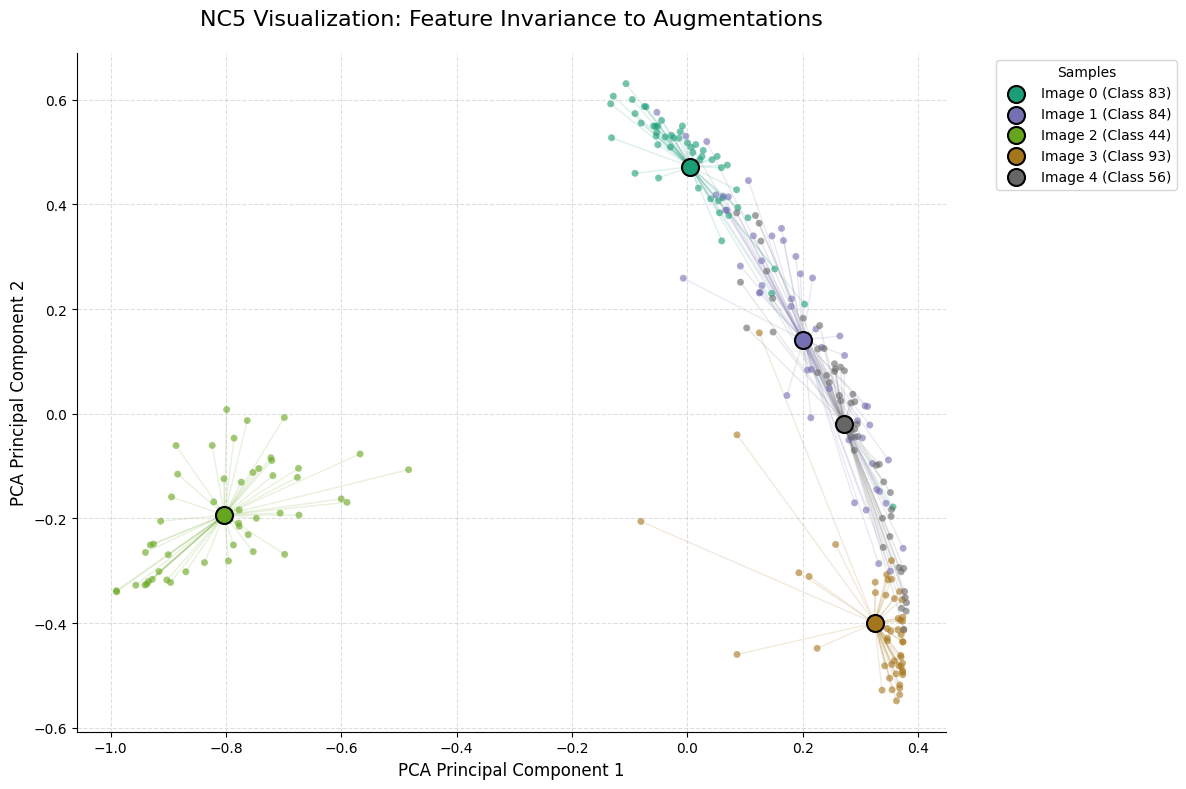

In [24]:
def plot_nc5_stars_professional(model, dataloader, transform_pipeline, n_images=6, n_augmentations=40):
    """
    Visualizes NC5 (Feature Invariance) by projecting augmented samples into 2D space.
    Each star represents one source image and its variations.
    """
    model.eval()
    device = next(model.parameters()).device
    
    images, labels = next(iter(dataloader))
    all_features = []
    group_ids = []
    class_names = []

    with torch.no_grad():
        for i in range(n_images):
            aug_imgs = torch.stack([transform_pipeline(images[i]) for _ in range(n_augmentations)]).to(device)
            
            output = model(aug_imgs)
            f = output[0] if isinstance(output, tuple) and output[0].dim() == 2 else output
            if isinstance(f, tuple): f = f[1]
            
            f = F.normalize(f, p=2, dim=1)
            
            all_features.append(f.cpu())
            group_ids.extend([i] * n_augmentations)
            class_names.append(labels[i].item())

    features_concat = torch.cat(all_features).numpy()
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features_concat)

    plt.figure(figsize=(12, 8), facecolor='white')
    colors = plt.cm.get_cmap('Dark2', n_images)
    
    for i in range(n_images):
        idx = np.where(np.array(group_ids) == i)[0]
        points = features_2d[idx]
        center = points.mean(axis=0)
        
        for p in points:
            plt.plot([center[0], p[0]], [center[1], p[1]], 
                     color=colors(i), alpha=0.15, lw=1, zorder=1)
        
        plt.scatter(points[:, 0], points[:, 1], 
                    color=colors(i), s=25, alpha=0.6, edgecolors='none', zorder=2)
        
        plt.scatter(center[0], center[1], 
                    color=colors(i), s=150, marker='o', edgecolors='black', 
                    linewidth=1.5, label=f"Image {i} (Class {class_names[i]})", zorder=3)

    plt.title("NC5 Visualization: Feature Invariance to Augmentations", fontsize=16, pad=20)
    plt.xlabel("PCA Principal Component 1", fontsize=12)
    plt.ylabel("PCA Principal Component 2", fontsize=12)
    
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Samples", frameon=True)
    
    plt.tight_layout()
    plt.show()

plot_nc5_stars_professional(
    model=model, 
    dataloader=train_loader, 
    transform_pipeline=test_invariance_transform,
    n_images=5, 
    n_augmentations=50
)